In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from torchqc.states import QuantumState
from torchqc.operators import Operator, DynamicOperator
from torchqc.dynamics import TDSE
from torchqc.common_functions import basis_operators

* Start from basis state $\ket{0}$

In [2]:
dims = 3
basis_states = QuantumState.basis(dims)
state = basis_states[0]

* Simulate dynamics with TDSE

In [3]:
T = 250
Dt = 0.1
time = np.arange(0, T + Dt, Dt, dtype = np.float32)
Ωo = 1
Ωp = Ωo
Ωs = Ωo
Γ = 1

In [4]:
T_tilde = 10
to = T / 2
time_tensor = torch.from_numpy(time).reshape(len(time), 1)

Ωp = Ωo * 1 / torch.sqrt(1 + 
                         torch.exp(- (time_tensor - to) / T_tilde))
Ωp.unsqueeze_(-1)
Ωp.expand(len(time), dims, dims)

Ωs = Ωo * 1 / torch.sqrt(1 + torch.exp((time_tensor - to) / T_tilde))
Ωs.unsqueeze_(-1)
Ωs.expand(len(time), dims, dims)

tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        ...,

        [[0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019]],

        [[0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019]],

        [[0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019],
         [0.0019, 0.0019, 0.0019]]])

* Construct Hamiltonian and simulate dynamics with TDSE

In [5]:
projectors, transitions, labels = basis_operators(dims)
_, proj2, _ = projectors
trans12, trans13, trans23 = transitions
trans21 = trans12.dagger()
trans32 = trans23.dagger()

In [6]:
H1_t = (Ωp / 2) * (trans12 + trans21)
H1 = DynamicOperator(dims=dims, Ht=H1_t.matrix)

H2_t = (Ωs / 2) * (trans23 + trans32)
H2 = DynamicOperator(dims=dims, Ht=H2_t.matrix)

H_loss = -1j * (Γ / 2) * proj2
H_loss = DynamicOperator(dims, H_loss.matrix.expand(len(Ωp), -1, -1))

hamiltonian = H1 + H2 + H_loss

states = TDSE(state, hamiltonian, time, Dt)

* Print Rabi oscillations

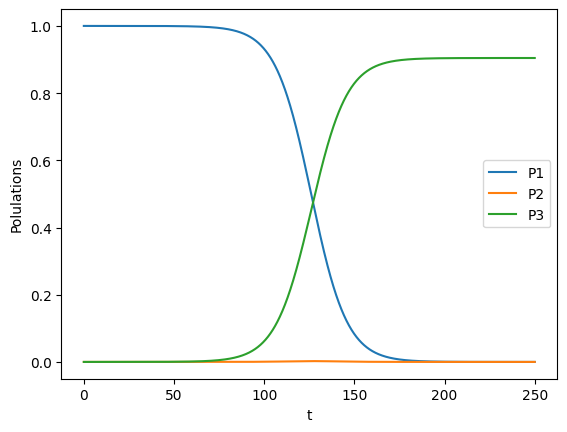

In [7]:
populations = np.array(
    [(torch.abs(state.state_tensor)**2).numpy() 
     for state in states]
    )

fig, ax = plt.subplots()

ax.plot(time, populations[:,0], label = "P1")
ax.plot(time, populations[:,1], label = "P2")
ax.plot(time, populations[:,2], label = "P3")
ax.set_ylabel("Polulations")
ax.set_xlabel("t")
ax.legend()